<a href="https://colab.research.google.com/github/HenriqueCCdA/BC_DS_Projeto_Final/blob/main/Notebooks/ML/treinamentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# 1) Resumo

Neste notebook foram feitos os treinamentos e seleção de hyperparamentros de 6 modelos de **ML** distintos. Os modelos estudados foram:

* DummyClassifier
* LogisticRegression
* DecisionTreeClassifier
* Forest Tree
* Support Vector Machine
* KNeighbors

A busca pelos hyperparametros foram feitas pelo GridSearchCV ou pelo RandomizedSearchCV. Para a Cross Validation foi usado **RepeatedStratifiedKFold** com **5** divições de **10** repetições.

O parametro utilizado para avaliação do modelo foi **ROC_AUC** e quantidade de **falsos negativos** (FN).

A base de dados utilizados tem **351** amostras com **52** variaveis explicativas. Dessas **351** amostras **298** foram usados para **Cross Validation** (treino + teste) e **53** foram usados para a **validação**.


---
# 2) Pre-analise

---
## 2.1) Minhas Funções

In [58]:
# Maquina Local 
try:
    import sys
    sys.path.insert(1, "../../")

    from src.plota_graficos import plota_treino_teste_auc, plota_curva_roc, plota_matriz_de_confusao
    from src.ml import retorna_x_y, intervalo_de_confianca, treina_modelo_grid_search_cv,\
                   treina_modelo_randomized_search_cv, obtem_os_resultados_SearchCV, cv_val_split, desempenho_dos_modelos 

    from src.info import proporcao_y, numero_teste_treino_val, resultados_treinamento, dimensao_dados, variaveis_explicativas

# Collab
except:
  !curl -O "https://raw.githubusercontent.com/HenriqueCCdA/BC_DS_Projeto_Final/main/requirements.txt"
  !pip3 install -r requirements.txt
  !curl -O "https://raw.githubusercontent.com/HenriqueCCdA/BC_DS_Projeto_Final/main/src/plota_graficos.py"
  !curl -O "https://raw.githubusercontent.com/HenriqueCCdA/BC_DS_Projeto_Final/main/src/ml.py"
  !curl -O "https://raw.githubusercontent.com/HenriqueCCdA/BC_DS_Projeto_Final/main/src/info.py"

  from plota_graficos import plota_treino_teste_auc, plota_curva_roc, plota_matriz_de_confusao
  from ml import retorna_x_y, intervalo_de_confianca, treina_modelo_grid_search_cv,\
                 treina_modelo_randomized_search_cv, obtem_os_resultados_SearchCV, cv_val_split, desempenho_dos_modelos

  from info import proporcao_y, numero_teste_treino_val, resultados_treinamento, dimensao_dados, variaveis_explicativas

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    79  100    79    0     0    434      0 --:--:-- --:--:-- --:--:--   434
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9240  100  9240    0     0  51049      0 --:--:-- --:--:-- --:--:-- 51049
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13221  100 13221    0     0  76866      0 --:--:-- --:--:-- --:--:-- 76866
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3936  100  3936    0     0  21988      0 --:--:-- --:--:-- --:--:-- 21988


---
## 2.2) Importando libs

In [59]:
import pandas as pd
#
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
#
import matplotlib.pyplot as plt
#
import numpy as np
#
from scipy.stats import uniform

## 2.3) Versão dos bibilotecas

In [60]:
import sklearn as sk
import scipy   as sc
import matplotlib as mpl

print(f'scipy      : {sc.__version__}')
print(f'sklearn    : {sk.__version__}')
print(f'pandas     : {pd.__version__}')
print(f'numpy      : {np.__version__}')
print(f'matplotlib : {mpl.__version__}')

scipy      : 1.6.2
sklearn    : 0.24.2
pandas     : 1.2.4
numpy      : 1.20.2
matplotlib : 3.3.4


In [61]:
def treina(modelo, x, y, parameters, n_splits, n_repeats, n_iter, seed, titulo, n):
    '''
    ----------------------------------------------------------------------------
    Treina e mostra os resultados
    ----------------------------------------------------------------------------
    '''

    resultados, melhor_modelo, hyperparametros  =\
        treina_modelo_randomized_search_cv(modelo,
                                          x_cv,
                                          y_cv,
                                          parameters,
                                          n_splits=n_splits,
                                          n_repeats=n_repeats,
                                          n_iter=n_iter,
                                          seed=seed)

    plota_treino_teste_auc(titulo, 
                         resultados['media_teste'],
                         resultados['media_treino'],
                         resultados['rank_test_score'],
                         hyperparametros)

    pd = resultados_treinamento(resultados, melhor_modelo, hyperparametros, n = n)

    return melhor_modelo, pd

---
# 3) Lendo os dados

In [62]:
path = "https://raw.githubusercontent.com/HenriqueCCdA/BC_DS_Projeto_Final/main/Dados/Tratados/dados_sem_coor_acima_do_valor_de_corte.csv"

dados_com_corte = pd.read_csv(path)

dimensao_dados(dados_com_corte)

dados_com_corte.tail(n=5)

Numero de linhas : 351 
Numero de colunas: 53 


,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,BE_ARTERIAL_MEDIAN,BE_VENOUS_MEDIAN,BIC_VENOUS_MEDIAN,BILLIRUBIN_MEDIAN,BLAST_MEDIAN,CALCIUM_MEDIAN,CREATININ_MEDIAN,FFA_MEDIAN,GGT_MEDIAN,GLUCOSE_MEDIAN,HEMATOCRITE_MEDIAN,INR_MEDIAN,LACTATE_MEDIAN,LEUKOCYTES_MEDIAN,LINFOCITOS_MEDIAN,P02_ARTERIAL_MEDIAN,P02_VENOUS_MEDIAN,PC02_ARTERIAL_MEDIAN,PC02_VENOUS_MEDIAN,PCR_MEDIAN,PH_ARTERIAL_MEDIAN,PH_VENOUS_MEDIAN,PLATELETS_MEDIAN,POTASSIUM_MEDIAN,SAT02_ARTERIAL_MEDIAN,SAT02_VENOUS_MEDIAN,SODIUM_MEDIAN,TGO_MEDIAN,TGP_MEDIAN,TTPA_MEDIAN,UREA_MEDIAN,DIMER_MEDIAN,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MAX,ICU
346,0,-0.333333,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.578947,-1.0,-1.000000,-0.317073,-0.293564,-1.0,0.326531,-0.937721,1.000000,-0.147196,-0.824953,-0.253669,-0.806775,1.000000,-0.704519,-0.879668,-0.170732,-0.704142,-0.77931,-0.754601,-0.565974,0.234043,0.363636,-0.895861,-0.629630,0.939394,0.345679,-0.428571,-0.925725,-0.981326,-0.629428,-0.860241,-0.978029,-0.160494,-0.692308,0.339623,-0.457627,0.142857,0.736842,-0.418803,1
347,1,1.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.605263,-1.0,-1.000000,-0.317073,-0.938950,-1.0,0.285714,-0.886766,-0.742004,-0.958528,-0.891993,-0.241090,-0.959849,1.000000,-0.794129,-0.921162,-0.170732,-0.704142,-0.77931,-0.754601,-0.993195,0.234043,0.363636,-0.516689,-0.518519,0.939394,0.345679,-0.314286,-0.998507,-0.995808,-0.846633,-0.855422,-0.978029,-0.407407,-0.692308,-0.283019,-0.457627,-0.059524,0.526316,-0.589744,0
348,0,-0.111111,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,-1.0,-1.000000,-0.317073,-0.938950,-1.0,0.357143,-0.905166,-0.742004,-0.958528,-0.891993,0.064990,-0.959849,1.000000,-0.718038,-0.838174,-0.170732,-0.704142,-0.77931,-0.754601,-0.034405,0.234043,0.363636,-0.658211,-0.407407,0.939394,0.345679,-0.085714,-0.995428,-0.986662,-0.846633,-0.787952,-0.964461,0.012346,-0.384615,-0.320755,-0.457627,-0.071429,0.894737,-0.299145,1
349,0,-0.333333,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,-1.0,-1.000000,-0.317073,-0.938950,-1.0,0.357143,-0.922151,-0.742004,-0.958528,-0.843575,-0.069182,-0.959849,1.000000,-0.877559,-0.819502,-0.170732,-0.704142,-0.77931,-0.754601,-0.804159,0.234043,0.363636,-0.623498,-0.555556,0.939394,0.345679,0.085714,-0.995428,-0.986662,-0.846633,-0.937349,-0.978029,0.086420,-0.230769,-0.301887,-0.661017,-0.107143,0.736842,-0.247863,0
350,0,-0.111111,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-0.717277,-0.170732,-0.982208,-1.0,0.244898,-0.934890,-0.782516,-0.960280,-0.862197,-0.064990,-0.957340,-0.897773,-0.848590,-0.686722,-0.170732,-0.857988,-0.77931,-0.730061,-0.906238,0.234043,0.424242,-0.479306,-0.333333,0.939394,-0.333333,-0.085714,-0.997387,-0.992378,-0.869210,-0.879518,-0.979571,0.012346,-0.292308,0.056604,-0.525424,0.535714,0.789474,-0.299145,0


In [63]:
dados_com_corte.describe()

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,BE_ARTERIAL_MEDIAN,BE_VENOUS_MEDIAN,BIC_VENOUS_MEDIAN,BILLIRUBIN_MEDIAN,BLAST_MEDIAN,CALCIUM_MEDIAN,CREATININ_MEDIAN,FFA_MEDIAN,GGT_MEDIAN,GLUCOSE_MEDIAN,HEMATOCRITE_MEDIAN,INR_MEDIAN,LACTATE_MEDIAN,LEUKOCYTES_MEDIAN,LINFOCITOS_MEDIAN,P02_ARTERIAL_MEDIAN,P02_VENOUS_MEDIAN,PC02_ARTERIAL_MEDIAN,PC02_VENOUS_MEDIAN,PCR_MEDIAN,PH_ARTERIAL_MEDIAN,PH_VENOUS_MEDIAN,PLATELETS_MEDIAN,POTASSIUM_MEDIAN,SAT02_ARTERIAL_MEDIAN,SAT02_VENOUS_MEDIAN,SODIUM_MEDIAN,TGO_MEDIAN,TGP_MEDIAN,TTPA_MEDIAN,UREA_MEDIAN,DIMER_MEDIAN,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MAX,ICU
count,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000
mean,0.458689,-0.046534,0.381766,0.108262,0.022792,0.091168,0.019943,0.128205,0.045584,0.196581,0.162393,0.811966,0.571900,-0.988680,-0.953730,-0.315266,-0.944913,-0.993560,0.328537,-0.892237,-0.728446,-0.932584,-0.856478,-0.119234,-0.942741,0.494624,-0.761648,-0.744157,-0.175266,-0.692577,-0.778151,-0.760963,-0.823305,0.236346,0.375982,-0.505947,-0.556822,0.928559,0.301959,-0.088807,-0.993806,-0.986840,-0.828954,-0.841746,-0.960159,-0.045990,-0.318411,-0.240403,-0.468207,0.097772,0.760029,-0.313074,0.461538
std,0.499002,0.640366,0.486513,0.311155,0.149453,0.288259,0.140004,0.334795,0.208879,0.397980,0.369338,0.391297,0.146607,0.086813,0.128238,0.090419,0.043857,0.107614,0.088826,0.099423,0.165901,0.147390,0.097183,0.226253,0.041537,0.837465,0.158005,0.153140,0.089491,0.128432,0.017829,0.051315,0.241212,0.047356,0.091409,0.209888,0.170066,0.115542,0.320451,0.208983,0.017485,0.015381,0.080423,0.135197,0.098682,0.253692,0.274796,0.278347,0.213326,0.272230,0.116880,0.185592,0.499230
min,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.578947,-1.000000,-1.000000,-1.000000,-0.994767,-1.000000,-0.040816,-0.978769,-0.918977,-0.997664,-1.000000,-1.000000,-1.000000,-0.992765,-1.000000,-1.000000,-1.000000,-1.000000,-0.862069,-1.000000,-1.000000,-0.319149,-0.090909,-1.000000,-1.000000,-1.000000,-1.000000,-0.828571,-1.000000,-0.999619,-0.961853,-0.971084,-1.000000,-0.654321,-0.938462,-0.823899,-0.954802,-0.571429,0.263158,-0.760684,0.000000
25%,0.000000,-0.555556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.605263,-1.000000,-1.000000,-0.317073,-0.963370,-1.000000,0.336735,-0.930644,-0.742004,-0.958528,-0.891993,-0.247379,-0.959849,-0.793745,-0.843183,-0.846473,-0.170732,-0.704142,-0.779310,-0.754601,-0.982231,0.234043,0.363636,-0.642190,-0.666667,0.939394,0.345679,-0.200000,-0.996921,-0.994665,-0.846633,-0.898795,-0.983811,-0.185185,-0.538462,-0.415094,-0.593220,-0.107143,0.684211,-0.418803,0.000000
50%,0.000000,-0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.605263,-1.000000,-1.000000,-0.317073,-0.938950,-1.000000,0.357143,-0.908402,-0.742004,-0.958528,-0.891993,-0.102725,-0.959849,1.000000,-0.795288,-0.790456,-0.170732,-0.704142,-0.779310,-0.754601,-0.906238,0.234043,0.363636,-0.540721,-0.555556,0.939394,0.345679,-0.085714,-0.995428,-0.988567,-0.846633,-0.874699,-0.978029,-0.037037,-0.369231,-0.283019,-0.525424,0.071429,0.789474,-0.299145,0.000000


In [64]:
_ = variaveis_explicativas(dados_com_corte)

 col[  0] -> AGE_ABOVE65                    col[  1] -> AGE_PERCENTIL                  
 col[  2] -> GENDER                         col[  3] -> DISEASE GROUPING 1             
 col[  4] -> DISEASE GROUPING 2             col[  5] -> DISEASE GROUPING 3             
 col[  6] -> DISEASE GROUPING 4             col[  7] -> DISEASE GROUPING 5             
 col[  8] -> DISEASE GROUPING 6             col[  9] -> HTN                            
 col[ 10] -> IMMUNOCOMPROMISED              col[ 11] -> OTHER                          
 col[ 12] -> ALBUMIN_MEDIAN                 col[ 13] -> BE_ARTERIAL_MEDIAN             
 col[ 14] -> BE_VENOUS_MEDIAN               col[ 15] -> BIC_VENOUS_MEDIAN              
 col[ 16] -> BILLIRUBIN_MEDIAN              col[ 17] -> BLAST_MEDIAN                   
 col[ 18] -> CALCIUM_MEDIAN                 col[ 19] -> CREATININ_MEDIAN               
 col[ 20] -> FFA_MEDIAN                     col[ 21] -> GGT_MEDIAN                     
 col[ 22] -> GLUCOSE_MEDIAN     

### Divindido os dados em validação e Cross Valadiation (teste+treino)

In [65]:
x_cv, x_val, y_cv, y_val = cv_val_split(dados_com_corte, p_val = .15)

### Verificando se a proporção foi mantida 

In [66]:
proporcao_y(dados_com_corte['ICU'])
proporcao_y(y_val)
proporcao_y(y_cv )

Proporcao do ICU
Campo 0 ->  53.85%
Campo 1 ->  46.15%
Proporcao do ICU
Campo 0 ->  54.72%
Campo 1 ->  45.28%
Proporcao do ICU
Campo 0 ->  53.69%
Campo 1 ->  46.31%


In [67]:
numero_teste_treino_val(dados_com_corte['ICU'], y_val, y_cv)

Número total de entradas                         : 351
Número total de entradas para validacao          : 53
Número total de entradas para o Cross Validation : 298


# 4) Modelo de ML

A opção **refit** foi deixado como **true** logo depois que o melhor modelo for selecioando o RandomizedSearchCV/GridSearchCv **re-treina** esse modelo com o dataset completo (treino+teste). 

In [68]:
n_iter   = 20
n_splits = 5
n_repeats= 10
seed     = 14715

## 4.1) DummyClassifier

> Aqui será treinado do modelo **DummyClassifier**. Para o treino foi usado **GridSearchCV**. O único hyperparametro disponivel foi **strategy**. O intervalor de busca  **[stratified, 'ost_frequent, prior, 'uniform]**. O DummyClassifier será usado como o nosso modelo **"baseline"**



In [69]:
modelo = DummyClassifier(random_state=seed)

parameters = {'strategy' : ['stratified', 'most_frequent', 'prior', 'uniform']}

resultados, melhor_modelo_dummy, melhores_hyperparametros  = treina_modelo_grid_search_cv(modelo,
                                                                                      x_cv,
                                                                                      y_cv,
                                                                                      parameters,
                                                                                      n_splits=n_splits,
                                                                                      n_repeats=n_repeats,
                                                                                      seed=seed)

resultados_treinamento(resultados, melhor_modelo_dummy, melhores_hyperparametros)

Fitting 50 folds for each of 4 candidates, totalling 200 fits
melhores hyperparametros : {'strategy': 'most_frequent'}
Melhor modelo            : DummyClassifier(random_state=14715, strategy='most_frequent')


,paramentros,media_teste,media_treino,std_teste,std_treino,mean_fit_time,std_fit_time,mean_score_time,std_score_time,rank_test_score
0,{'strategy': 'stratified'},0.499906,0.47666,0.064922,0.025648,0.000915,0.000167,0.001268,0.000140,4
1,{'strategy': 'most_frequent'},0.500000,0.50000,0.000000,0.000000,0.000958,0.000195,0.001360,0.000366,1
2,{'strategy': 'prior'},0.500000,0.50000,0.000000,0.000000,0.000818,0.000068,0.001198,0.000141,1
3,{'strategy': 'uniform'},0.500000,0.50000,0.000000,0.000000,0.000832,0.000086,0.001187,0.000091,1


---
## 4.2) Regreção logistica

> Aqui será treinado do modelo **LogisticRegression**. No treino foi usado **RandomizedSearchCV** com **50** iterações. Os hyperparametros foram:
>* C             : [0, 4]


Fitting 50 folds for each of 20 candidates, totalling 1000 fits


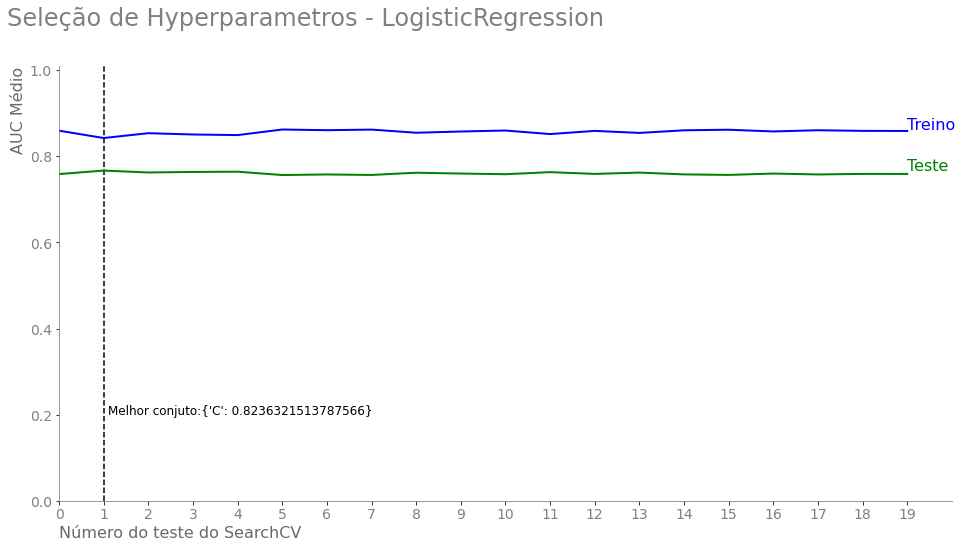

melhores hyperparametros : {'C': 0.8236321513787566}
Melhor modelo            : LogisticRegression(C=0.8236321513787566, max_iter=1000, tol=1e-06)


,paramentros,media_teste,media_treino,std_teste,std_treino,mean_fit_time,std_fit_time,mean_score_time,std_score_time,rank_test_score
0,{'C': 2.9403726439047437},0.758822,0.859603,0.047317,0.010994,0.031686,0.006052,0.004355,0.000639,13
1,{'C': 0.8236321513787566},0.766940,0.842530,0.050431,0.011372,0.018211,0.002464,0.004168,0.000522,1
2,{'C': 1.8107081253404766},0.762514,0.853759,0.047908,0.011036,0.025056,0.004668,0.004319,0.000511,5
3,{'C': 1.4507591152545065},0.763743,0.850744,0.048855,0.011129,0.021407,0.002593,0.004114,0.000603,3
4,{'C': 1.3163817298661398},0.764355,0.849348,0.049295,0.011099,0.020914,0.002874,0.004123,0.000373,2
5,{'C': 3.7627108804741063},0.756595,0.862307,0.046378,0.010939,0.033303,0.004549,0.004365,0.000956,20
6,{'C': 3.2348466053974367},0.757917,0.860721,0.046917,0.010931,0.032184,0.005755,0.004203,0.000387,17
7,{'C': 3.6987640689695644},0.756771,0.862128,0.046713,0.010934,0.032973,0.004413,0.004194,0.000238,19
8,{'C': 1.9704679412547428},0.761989,0.854794,0.047582,0.011042,0.024467,0.003648,0.004163,0.000469,7
9,{'C': 2.4854242092996466},0.760031,0.857677,0.047388,0.011048,0.027114,0.003497,0.004086,0.000143,8


In [70]:
parameters = {'C': uniform(loc=0, scale=4)}
modelo = LogisticRegression(max_iter=1000, tol=1e-6)

melhor_modelo_lr, res = treina(modelo = modelo,
                        x = x_cv, 
                        y = y_cv, 
                        parameters = parameters, 
                        n_splits = n_splits, 
                        n_repeats = n_repeats, 
                        n_iter = n_iter, 
                        seed = seed, 
                        titulo = 'Seleção de Hyperparametros - LogisticRegression',
                        n = 20)

res

---
## 4.3) Arvore de decissão

> Aqui será treinado do modelo **DecisionTreeClassifier**. No treino foi usado **RandomizedSearchCV** com **50** iterações. Os hyperparametros foram:
>* max_depth       : [1-20]
>* criterion       : [gini, entropy]
>* min_samples_leaf: [1-5]
>* max_leaf_nodes  : [2-5]


Fitting 50 folds for each of 20 candidates, totalling 1000 fits


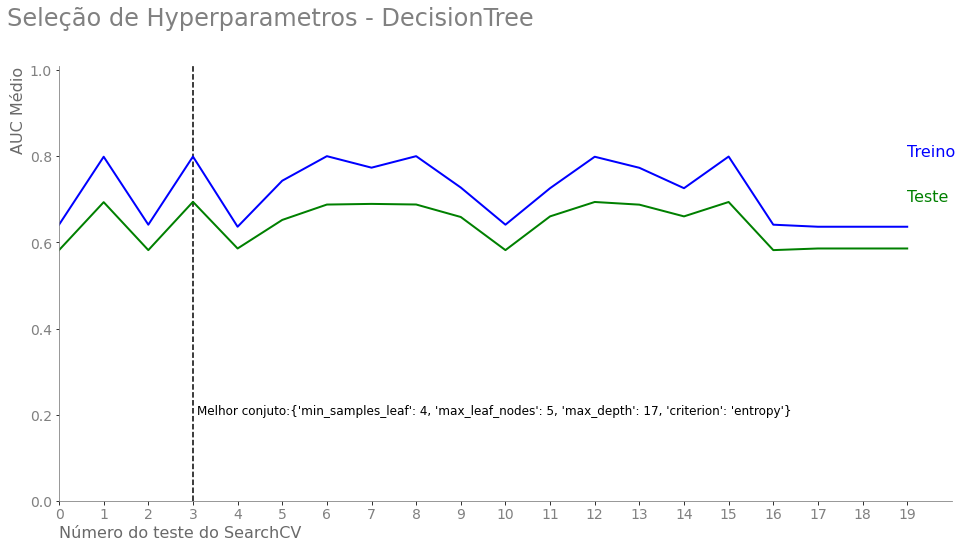

melhores hyperparametros : {'min_samples_leaf': 4, 'max_leaf_nodes': 5, 'max_depth': 17, 'criterion': 'entropy'}
Melhor modelo            : DecisionTreeClassifier(criterion='entropy', max_depth=17, max_leaf_nodes=5,
                       min_samples_leaf=4)


,paramentros,media_teste,media_treino,std_teste,std_treino,mean_fit_time,std_fit_time,mean_score_time,std_score_time,rank_test_score
0,"{'min_samples_leaf': 5, 'max_leaf_nodes': 2, '...",0.582206,0.641261,0.040914,0.018957,0.003537,0.000210,0.002829,0.000239,17
1,"{'min_samples_leaf': 1, 'max_leaf_nodes': 5, '...",0.693582,0.799081,0.061494,0.016427,0.005580,0.000443,0.003113,0.000320,4
2,"{'min_samples_leaf': 5, 'max_leaf_nodes': 2, '...",0.582206,0.641261,0.040914,0.018957,0.003727,0.000478,0.002989,0.000365,17
3,"{'min_samples_leaf': 4, 'max_leaf_nodes': 5, '...",0.694364,0.799527,0.061409,0.015958,0.005433,0.000371,0.003127,0.000289,1
4,"{'min_samples_leaf': 5, 'max_leaf_nodes': 2, '...",0.585997,0.636495,0.043541,0.018728,0.004071,0.000349,0.002953,0.000710,13
5,"{'min_samples_leaf': 4, 'max_leaf_nodes': 5, '...",0.652319,0.743382,0.059546,0.014471,0.003640,0.000300,0.002976,0.000334,12
6,"{'min_samples_leaf': 2, 'max_leaf_nodes': 5, '...",0.688020,0.800398,0.060561,0.013906,0.004322,0.000341,0.002984,0.000529,7
7,"{'min_samples_leaf': 3, 'max_leaf_nodes': 4, '...",0.689549,0.773702,0.062202,0.016121,0.005011,0.000210,0.002915,0.000280,5
8,"{'min_samples_leaf': 3, 'max_leaf_nodes': 5, '...",0.688143,0.800398,0.060425,0.013906,0.004246,0.000265,0.002885,0.000195,6
9,"{'min_samples_leaf': 3, 'max_leaf_nodes': 3, '...",0.659116,0.727499,0.058655,0.010904,0.003836,0.000433,0.002869,0.000531,11


In [71]:
parameters = {'max_depth'       : np.arange(1, 21),
              'criterion'       : ['gini', 'entropy'],
              'min_samples_leaf': np.arange(1, 6),
              'max_leaf_nodes'  : np.arange(2, 6)
             }
modelo = DecisionTreeClassifier()

melhor_modelo_arvore, res = treina(modelo = modelo,
                            x = x_cv, 
                            y = y_cv, 
                            parameters = parameters, 
                            n_splits = n_splits, 
                            n_repeats = n_repeats, 
                            n_iter = n_iter, 
                            seed = seed, 
                            titulo = 'Seleção de Hyperparametros - DecisionTree',
                            n = 20)

res

---
## 4.4) Forest Tree

> Aqui será treinado do modelo **Forest Tree**. No treino foi usado **RandomizedSearchCV** com **10** iterações. Os hyperparametros foram:
>* n_estimators    : [10, 50, 100, 150, 200]
>* max_depth       : [1, 20]    
>* criterion       : [gini, entropy]
>* min_samples_leaf: [1-5]
>* max_leaf_nodes  : [2-5]


Fitting 50 folds for each of 20 candidates, totalling 1000 fits


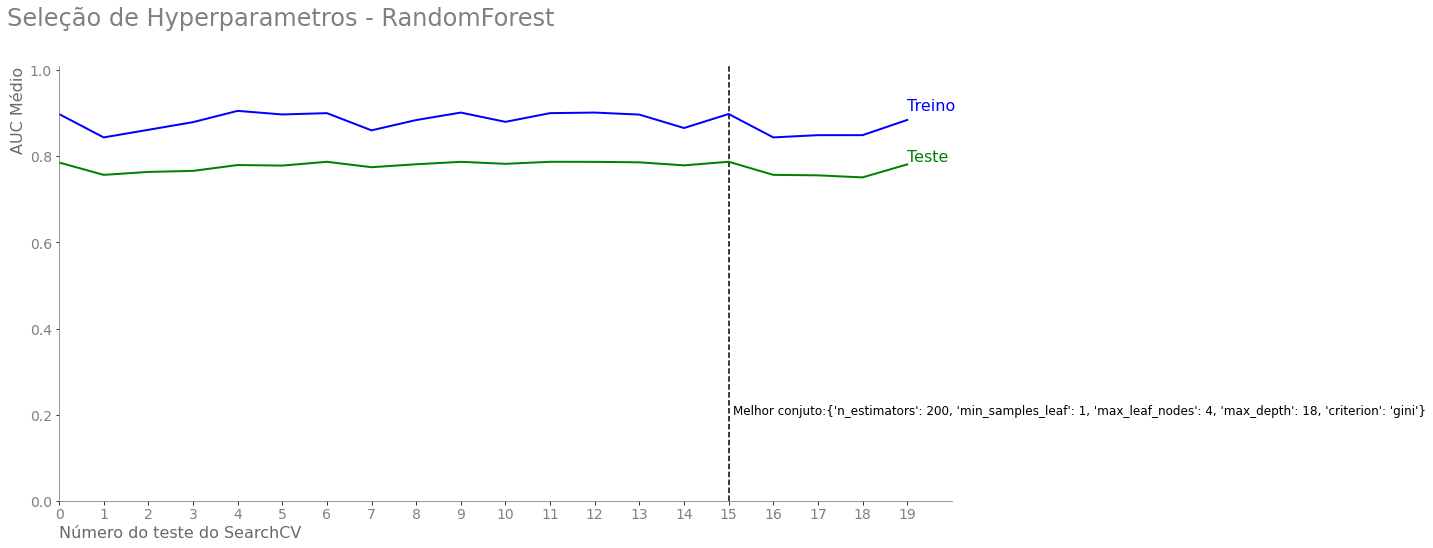

melhores hyperparametros : {'n_estimators': 200, 'min_samples_leaf': 1, 'max_leaf_nodes': 4, 'max_depth': 18, 'criterion': 'gini'}
Melhor modelo            : RandomForestClassifier(max_depth=18, max_leaf_nodes=4, n_estimators=200,
                       random_state=0)


,paramentros,media_teste,media_treino,std_teste,std_treino,mean_fit_time,std_fit_time,mean_score_time,std_score_time,rank_test_score
0,"{'n_estimators': 200, 'min_samples_leaf': 3, '...",0.785713,0.898272,0.047363,0.009178,0.244648,0.005207,0.022169,0.001869,7
1,"{'n_estimators': 50, 'min_samples_leaf': 4, 'm...",0.756954,0.843948,0.048437,0.015207,0.062958,0.002594,0.008114,0.000920,18
2,"{'n_estimators': 10, 'min_samples_leaf': 2, 'm...",0.763854,0.861591,0.055292,0.014399,0.016229,0.001384,0.004447,0.000440,16
3,"{'n_estimators': 10, 'min_samples_leaf': 4, 'm...",0.766212,0.879368,0.051952,0.013635,0.016310,0.001084,0.004446,0.000410,15
4,"{'n_estimators': 50, 'min_samples_leaf': 5, 'm...",0.779816,0.905590,0.048517,0.009737,0.066523,0.002142,0.008144,0.000674,11
5,"{'n_estimators': 50, 'min_samples_leaf': 3, 'm...",0.778539,0.897271,0.051833,0.010679,0.071011,0.002312,0.008511,0.001183,13
6,"{'n_estimators': 200, 'min_samples_leaf': 5, '...",0.787319,0.900330,0.048795,0.009046,0.270335,0.011002,0.022777,0.002783,2
7,"{'n_estimators': 150, 'min_samples_leaf': 4, '...",0.774774,0.860370,0.049999,0.012240,0.181646,0.003907,0.017670,0.001881,14
8,"{'n_estimators': 100, 'min_samples_leaf': 3, '...",0.781609,0.884294,0.052284,0.011595,0.133081,0.002990,0.012779,0.001488,9
9,"{'n_estimators': 200, 'min_samples_leaf': 3, '...",0.787245,0.901639,0.049110,0.009326,0.270022,0.004527,0.022424,0.002586,4


In [83]:
parameters = {'n_estimators'    : [10, 50, 100, 150, 200],
              'max_depth'       : np.arange(1, 21),
              'criterion'       : ['gini', 'entropy'],
              'min_samples_leaf': np.arange(1, 6),
              'max_leaf_nodes'  : np.arange(2, 6)
             }
modelo = RandomForestClassifier(random_state=0)

melhor_modelo_forest, res = treina(modelo = modelo,
                              x = x_cv, 
                              y = y_cv, 
                              parameters = parameters, 
                              n_splits = n_splits, 
                              n_repeats = n_repeats, 
                              n_iter = n_iter, 
                              seed = seed, 
                              titulo = 'Seleção de Hyperparametros - RandomForest',
                              n = 20)

res

> 

## 4.5) Support Vector Classification.

> Aqui será treinado do modelo **SVC**. No treino foi usado **RandomizedSearchCV** com **50** iterações. Os hyperparametros de busca foram
>* kernel        : [linear, poly, rbf, sigmoid]
>* C             : [0, 2]
>* gamma         : [scale, auto]
>* shrinking     : [True , False]

Fitting 50 folds for each of 20 candidates, totalling 1000 fits


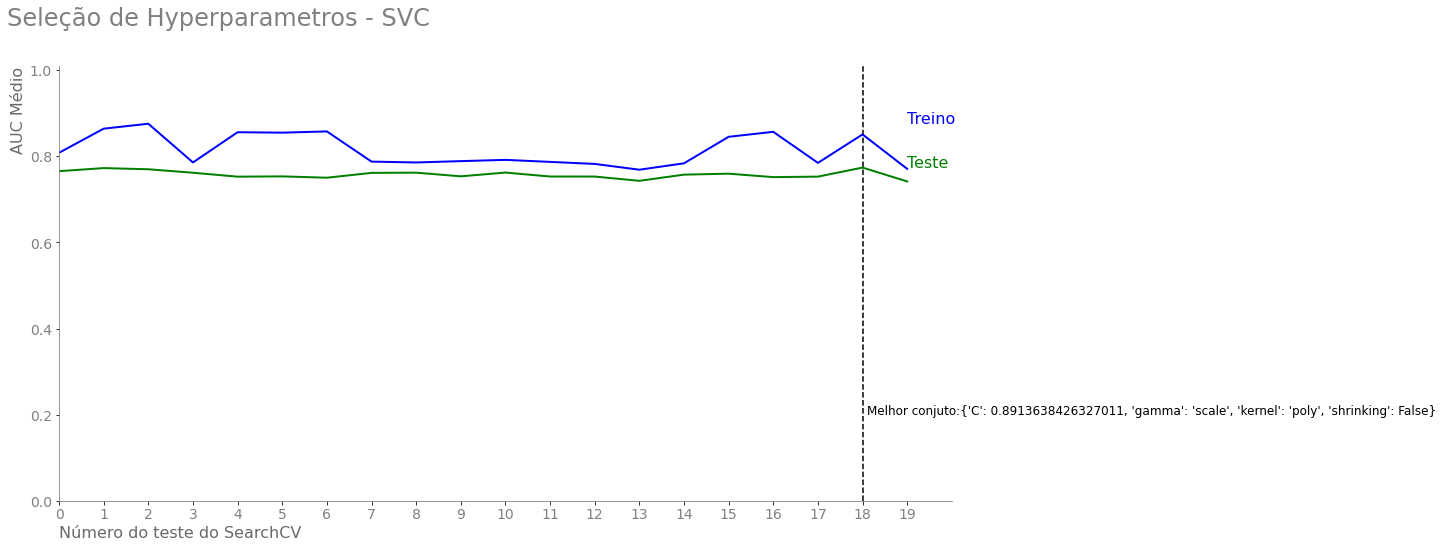

melhores hyperparametros : {'C': 0.8913638426327011, 'gamma': 'scale', 'kernel': 'poly', 'shrinking': False}
Melhor modelo            : SVC(C=0.8913638426327011, kernel='poly', probability=True, shrinking=False)


,paramentros,media_teste,media_treino,std_teste,std_treino,mean_fit_time,std_fit_time,mean_score_time,std_score_time,rank_test_score
0,"{'C': 1.4701863219523719, 'gamma': 'auto', 'ke...",0.765557,0.808340,0.051067,0.011437,0.017903,0.001183,0.004251,0.000271,4
1,"{'C': 1.3271690214081076, 'gamma': 'scale', 'k...",0.772682,0.864274,0.051079,0.009677,0.011650,0.000935,0.003478,0.000181,2
2,"{'C': 1.8813554402370531, 'gamma': 'scale', 'k...",0.769981,0.875712,0.051461,0.009883,0.011863,0.000698,0.003536,0.000264,3
3,"{'C': 0.872565127799168, 'gamma': 'auto', 'ker...",0.761906,0.785844,0.049513,0.011223,0.012247,0.000323,0.003761,0.000363,7
4,"{'C': 1.5194866996222245, 'gamma': 'auto', 'ke...",0.752799,0.856033,0.053631,0.012397,0.016529,0.001409,0.003468,0.000187,16
5,"{'C': 1.375029228314785, 'gamma': 'auto', 'ker...",0.753451,0.854986,0.053154,0.012293,0.013070,0.000636,0.003490,0.000342,12
6,"{'C': 1.7923741955744268, 'gamma': 'scale', 'k...",0.750364,0.857883,0.054117,0.012719,0.017863,0.001233,0.003590,0.000401,18
7,"{'C': 1.206530015269424, 'gamma': 'auto', 'ker...",0.761588,0.787759,0.049323,0.011584,0.011643,0.000591,0.003459,0.000633,8
8,"{'C': 0.010175292060016439, 'gamma': 'scale', ...",0.762087,0.785774,0.049395,0.011150,0.012439,0.001379,0.003556,0.000364,6
9,"{'C': 1.8515891573884744, 'gamma': 'auto', 'ke...",0.753600,0.788889,0.049108,0.011892,0.017285,0.000812,0.003815,0.000279,11


In [80]:
parameters = {'kernel'          : ['linear', 'poly', 'rbf', 'sigmoid'],
              'C'               : uniform(loc=0, scale=2),
              'gamma'           : ['scale', 'auto'],
              'shrinking'       : [True, False]
             }

modelo = SVC(probability=True)

melhor_modelo_svc, res = treina(modelo = modelo,
                              x = x_cv, 
                              y = y_cv, 
                              parameters = parameters, 
                              n_splits = n_splits, 
                              n_repeats = n_repeats, 
                              n_iter = n_iter, 
                              seed = seed, 
                              titulo = 'Seleção de Hyperparametros - SVC',
                              n = 20)

res

## 4.5) KNeighbors

> Aqui será treinado do modelo **KNeighbor**. No treino foi usado **RandomizedSearchCV** com **50** iterações. Os hyperparametros de busca foram
>* n_neighbors   : [1, 10]
>* p             : [1, 2]
>* weights       : [uniform, distance]
>* algorithm     : [auto, ball_tree, kd_tree, brute]

Fitting 50 folds for each of 20 candidates, totalling 1000 fits


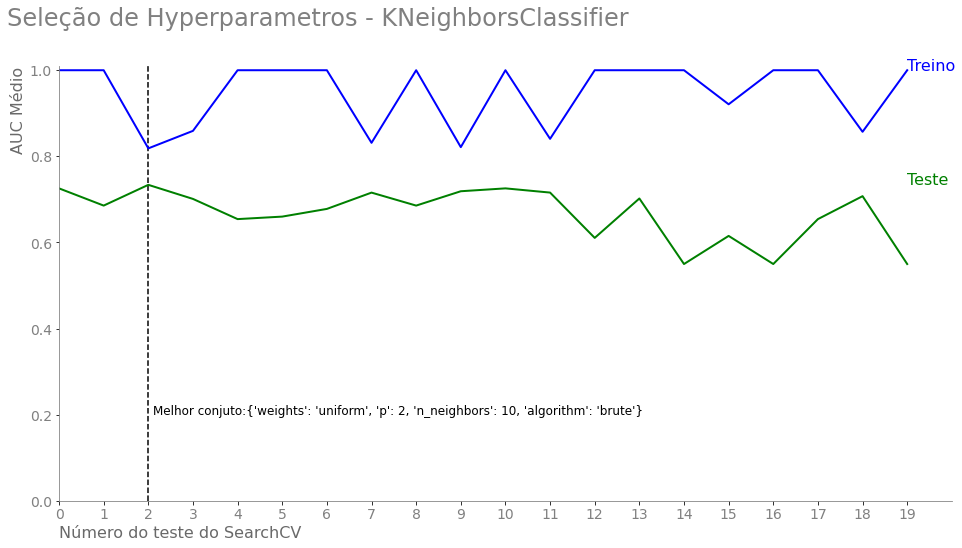

melhores hyperparametros : {'weights': 'uniform', 'p': 2, 'n_neighbors': 10, 'algorithm': 'brute'}
Melhor modelo            : KNeighborsClassifier(algorithm='brute', n_neighbors=10)


,paramentros,media_teste,media_treino,std_teste,std_treino,mean_fit_time,std_fit_time,mean_score_time,std_score_time,rank_test_score
0,"{'weights': 'distance', 'p': 2, 'n_neighbors':...",0.725608,1.000000,0.062448,0.000000,0.003876,0.000287,0.005131,0.000857,2
1,"{'weights': 'distance', 'p': 2, 'n_neighbors':...",0.685618,1.000000,0.061228,0.000000,0.003812,0.000386,0.004786,0.000246,10
2,"{'weights': 'uniform', 'p': 2, 'n_neighbors': ...",0.733804,0.818502,0.060703,0.011719,0.003875,0.000453,0.004935,0.000309,1
3,"{'weights': 'uniform', 'p': 1, 'n_neighbors': ...",0.701123,0.859178,0.057447,0.013178,0.003040,0.000465,0.003960,0.000504,9
4,"{'weights': 'distance', 'p': 1, 'n_neighbors':...",0.654229,1.000000,0.056716,0.000000,0.003341,0.000164,0.004492,0.000705,14
5,"{'weights': 'distance', 'p': 2, 'n_neighbors':...",0.660041,1.000000,0.063068,0.000000,0.003356,0.000305,0.004290,0.000558,13
6,"{'weights': 'distance', 'p': 1, 'n_neighbors':...",0.677913,1.000000,0.057755,0.000000,0.002839,0.000277,0.003760,0.000359,12
7,"{'weights': 'uniform', 'p': 1, 'n_neighbors': ...",0.715767,0.831408,0.063137,0.014058,0.002787,0.000122,0.003775,0.000402,6
8,"{'weights': 'distance', 'p': 2, 'n_neighbors':...",0.685618,1.000000,0.061228,0.000000,0.003341,0.000279,0.004205,0.000278,10
9,"{'weights': 'uniform', 'p': 1, 'n_neighbors': ...",0.718941,0.821372,0.063398,0.014390,0.003330,0.000312,0.004335,0.000451,4


In [79]:
parameters = {'n_neighbors'     : np.arange(1, 11),
              'p'               : [1, 2],
              'weights'         : ['uniform', 'distance'],
              'algorithm'       : ['auto', 'ball_tree', 'kd_tree', 'brute']
             }

modelo = KNeighborsClassifier()

melhor_modelo_kn, res = treina(modelo = modelo,
                              x = x_cv, 
                              y = y_cv, 
                              parameters = parameters, 
                              n_splits = n_splits, 
                              n_repeats = n_repeats, 
                              n_iter = n_iter, 
                              seed = seed, 
                              titulo = 'Seleção de Hyperparametros - KNeighborsClassifier',
                              n = 20)

res


# 5) Avaliando o melhor modelo

> Agora vamos avaliar o melhor modelo encontrado utilizando o dados de validação.

In [86]:
modelos = [melhor_modelo_dummy, 
           melhor_modelo_lr, 
           melhor_modelo_arvore, 
           melhor_modelo_forest, 
           melhor_modelo_svc,
           melhor_modelo_kn] 

In [87]:
desempenho_dos_modelos(modelos, x_val, y_val)

,Name,tn,fp,fn,tp,AUC
0,RandomForestClassifier,25,4,10,14,0.866379
1,SVC,25,4,6,18,0.864943
2,LogisticRegression,25,4,8,16,0.830460
3,KNeighborsClassifier,27,2,14,10,0.775862
4,DecisionTreeClassifier,22,7,5,19,0.767241
5,DummyClassifier,29,0,24,0,0.500000


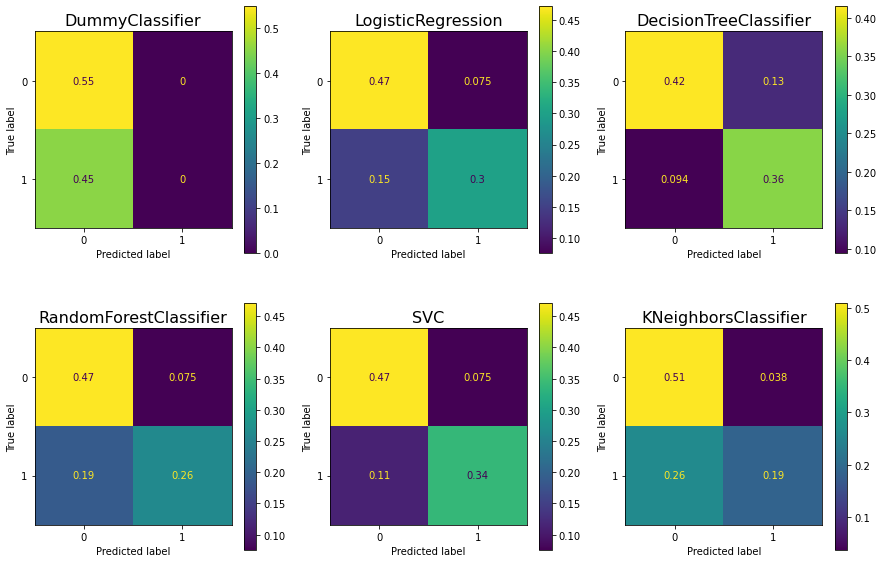

In [88]:
plota_matriz_de_confusao(modelos, x_val, y_val)

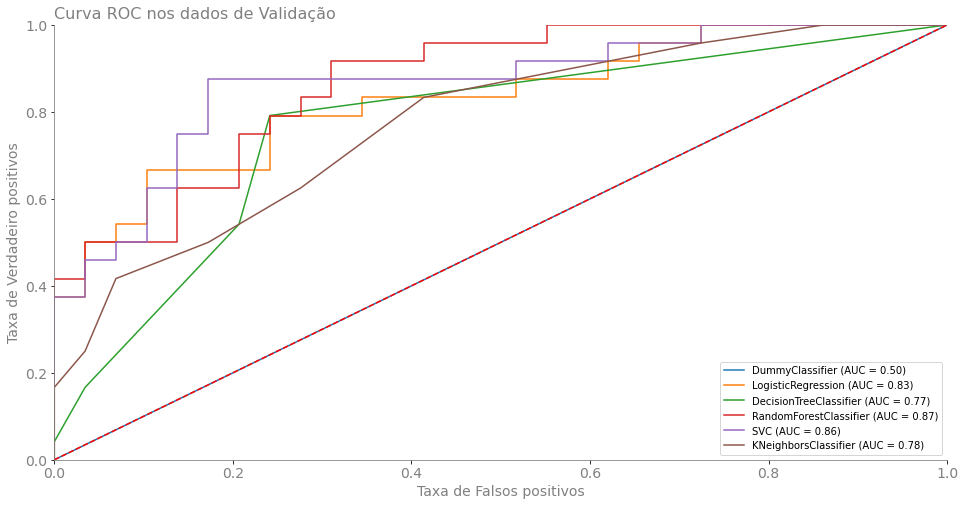

In [89]:
plota_curva_roc(modelos, titulo='Curva ROC nos dados de Validação', x=x_val, y=y_val)

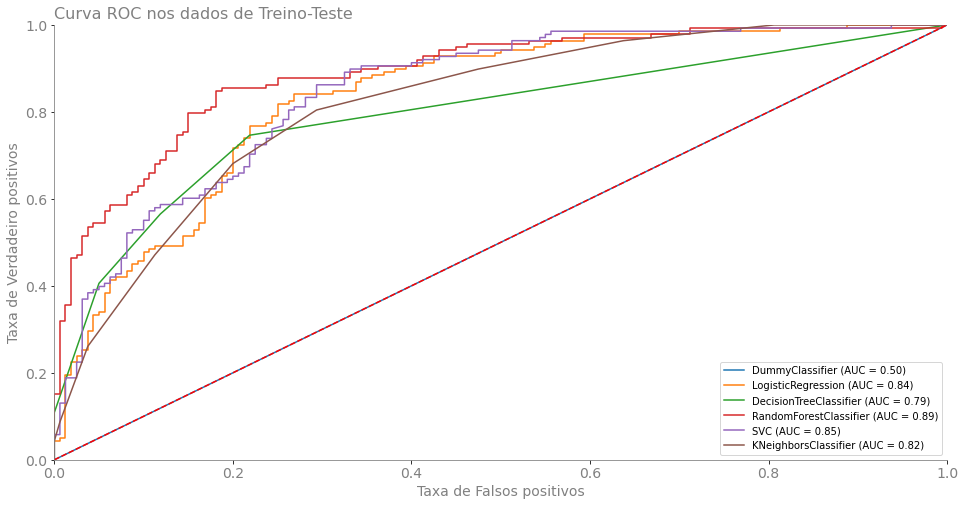

In [90]:
plota_curva_roc(modelos, titulo='Curva ROC nos dados de Treino-Teste', x=x_cv, y=y_cv)